# Naïve Bayes Classifier

Probability is a way to figure out how likely something is to happen. Probability is calculated by taking the number of chances something can happen and divide it by the total number of possible outcomes. For example, when flipping a coin there are 2 possible outcomes. The probability of getting heads is 50% (1 chance to get heads, with 2 possible outcomes). The formula would look like:

### \begin{align} probability = \frac{number of chances}{total outcomes} \end{align}

The Naïve Bayes classification model is an algorithm based on Bayes' Theorem, which is a way to find the probability of a variable when other values have been known to occur already. It is represented by the following formula:

### \begin{align} P(B|A) = \frac{P(B)\times P(A|B)}{P(A)} \end{align}

Where the probability of B given that A happened is equal to the probability of B times the probability of A given that B happened, divided by the probability of A. For example, in a bag of 2 blue marbles and 3 red marbles, if a blue marble is pulled from the bag then the probability of getting another blue marble is affected by the fact that a blue marble was already drawn (and thus, there are fewer blue marbles in the bag).

<center>![Marbles Probability](https://notebooks.azure.com/priesterkc/projects/testdb/raw/marbles.png "Probability using marbles")</center>

## Naïve Bayes Probability Calculation

In the following dataset, let's find the probability of a student passing a test (60% or higher) given that they studied 5 hours or less. Here are the things we'll need to know:

- the total number of students
- the number of students that passed the test
- the number of students that studied 5 hours or less
- the number of students that studied 5 hours or less, given that they already passed

Using those values, then we can calculate:

- the probability of passing the test
- the probability of studying 5 hours or less
- the probability of studying 5 hours or less, given already passing the test

In [11]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [12]:
#import Excel file

location = "datasets/titanic.xls"
df = pd.read_excel(location) #overwrites the info from the df variable in the examples above
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Explore through visualized data

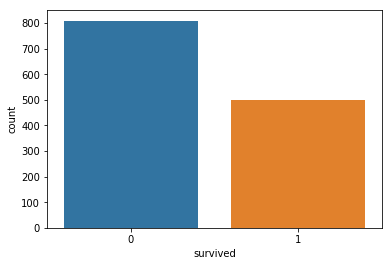

In [13]:
#bar chart of survival status count
sns.countplot(x='survived', data=df)

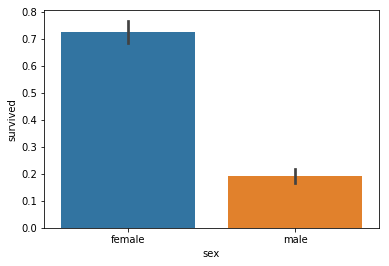

In [14]:
#survival status by sex
sns.barplot('sex', 'survived', data=df)

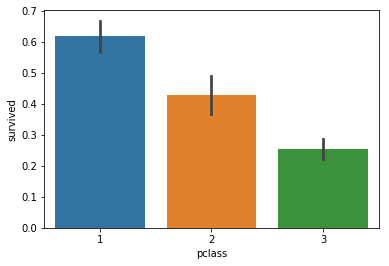

In [15]:
#survival rate by passenger class
sns.barplot('pclass', 'survived', data=df)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


[Text(0.5, 0, 'Age')]

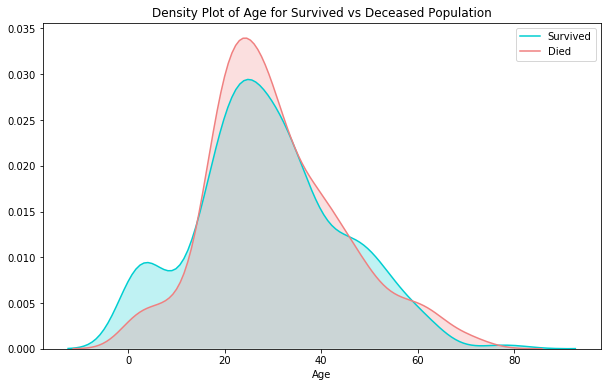

In [16]:
#plot age by survival status
plt.figure(figsize=(10,6))

ax = sns.kdeplot(df['age'][df['survived'] == 1], #passengers that survived
                 color="darkturquoise",
                 shade=True)

sns.kdeplot(df['age'][df['survived'] == 0], #passengers that did not survive
            color="lightcoral",
            shade=True)

plt.legend (['Survived', 'Died'])
plt.title("Density Plot of Age for Survived vs Deceased Population")

ax.set(xlabel='Age')
#plt.show()

Handle missing values

In [17]:
#find columns that have missing values
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [18]:
#rows where the age is missing
missing_age = df.loc[df['age'].isnull()]
missing_age.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
15,1,0,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S,NaN,NaN,"New York, NY"
37,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,111427,26.5500,NaN,S,9,NaN,"Los Angeles, CA"
40,1,0,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,NaN,NaN,"Philadelphia, PA"
46,1,0,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S,NaN,NaN,NaN
59,1,1,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",female,NaN,0,0,17770,27.7208,NaN,C,5,NaN,"New York, NY"


In [19]:
#get index numbers of missing rows - we'll use this later
mals = list(missing_age.index)

In [20]:
#table of avg age of passenger by survival status, sex, and passenger class
df.groupby(['survived', 'sex', 'pclass'])['age'].mean()

survived  sex     pclass
0         female  1         35.200000
                  2         34.090909
                  3         23.418750
          male    1         43.658163
                  2         33.092593
                  3         26.679598
1         female  1         37.109375
                  2         26.711051
                  3         20.814815
          male    1         36.168240
                  2         17.449274
                  3         22.436441
Name: age, dtype: float64

In [21]:
#fill missing values for age based on survival status, sex, and passenger class
df['age'].fillna(df.groupby(['survived', 'sex', 'pclass'])['age'].transform('mean'), inplace=True)

In [22]:
#verify filled missing values 
df.iloc[mals].head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
15,1,0,"Baumann, Mr. John D",male,43.658163,0,0,PC 17318,25.9250,NaN,S,NaN,NaN,"New York, NY"
37,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,36.168240,0,0,111427,26.5500,NaN,S,9,NaN,"Los Angeles, CA"
40,1,0,"Brewe, Dr. Arthur Jackson",male,43.658163,0,0,112379,39.6000,NaN,C,NaN,NaN,"Philadelphia, PA"
46,1,0,"Cairns, Mr. Alexander",male,43.658163,0,0,113798,31.0000,NaN,S,NaN,NaN,NaN
59,1,1,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",female,37.109375,0,0,17770,27.7208,NaN,C,5,NaN,"New York, NY"


In [23]:
#verify there are no more missing age values
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [24]:
#missing values for 'embarked'
embark = df.loc[df['embarked'].isnull()]
embark

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
168,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,6,NaN,NaN
284,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,6,NaN,"Cincinatti, OH"


In [25]:
#save index for missing values to verify later
embarkls = list(embark.index)

In [26]:
#only 2 missing values so we'll fill with most common embarkation point
df['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [27]:
#fill missing values
df['embarked'].fillna('S', inplace=True)

In [28]:
#check that they're filled
df.iloc[embarkls]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
168,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S,6,NaN,NaN
284,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S,6,NaN,"Cincinatti, OH"


In [29]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age             0
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        0
boat          823
body         1188
home.dest     564
dtype: int64

Get rid of columns that we don't want to use in the model

In [30]:
modeldf = df.drop(['name','ticket','fare', 'cabin', 'boat', 'body', 'home.dest'], axis=1)

In [31]:
#columns left in our dataframe
modeldf.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'embarked'], dtype='object')

Create dummy variables for categorical values

In [32]:
#dummy variables for passenger class embarkation port
#get_dummies will auto-drop columns that dummies were created from
modeldf = pd.get_dummies(data=modeldf, columns=['pclass','embarked'])
modeldf.head()

,survived,sex,age,sibsp,parch,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,1,female,29.0000,0,0,1,0,0,0,0,1
1,1,male,0.9167,1,2,1,0,0,0,0,1
2,0,female,2.0000,1,2,1,0,0,0,0,1
3,0,male,30.0000,1,2,1,0,0,0,0,1
4,0,female,25.0000,1,2,1,0,0,0,0,1


In [33]:
#change sex values to binary
#female=0, male=1
modeldf['sex'] = modeldf['sex'].map({'female':0, 'male':1})
modeldf.head()

,survived,sex,age,sibsp,parch,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,1,0,29.0000,0,0,1,0,0,0,0,1
1,1,1,0.9167,1,2,1,0,0,0,0,1
2,0,0,2.0000,1,2,1,0,0,0,0,1
3,0,1,30.0000,1,2,1,0,0,0,0,1
4,0,0,25.0000,1,2,1,0,0,0,0,1


In [34]:
#create new column based on number of family members
#drop sibsp and parch columns
modeldf['family_num'] = modeldf['sibsp'] + modeldf['parch']
modeldf.drop(['sibsp', 'parch'], axis=1, inplace=True)
modeldf.head()

,survived,sex,age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,family_num
0,1,0,29.0000,1,0,0,0,0,1,0
1,1,1,0.9167,1,0,0,0,0,1,3
2,0,0,2.0000,1,0,0,0,0,1,3
3,0,1,30.0000,1,0,0,0,0,1,3
4,0,0,25.0000,1,0,0,0,0,1,3


In [35]:
modeldf['TravelAlone']=np.where((modeldf['family_num'] > 0), 0, 1)
modeldf.head()

,survived,sex,age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,family_num,TravelAlone
0,1,0,29.0000,1,0,0,0,0,1,0,1
1,1,1,0.9167,1,0,0,0,0,1,3,0
2,0,0,2.0000,1,0,0,0,0,1,3,0
3,0,1,30.0000,1,0,0,0,0,1,3,0
4,0,0,25.0000,1,0,0,0,0,1,3,0


In [37]:
df = modeldf
df.head()

,survived,sex,age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,family_num,TravelAlone
0,1,0,29.0000,1,0,0,0,0,1,0,1
1,1,1,0.9167,1,0,0,0,0,1,3,0
2,0,0,2.0000,1,0,0,0,0,1,3,0
3,0,1,30.0000,1,0,0,0,0,1,3,0
4,0,0,25.0000,1,0,0,0,0,1,3,0


In [38]:
#descriptive statistics
df.describe()

,survived,sex,age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,family_num,TravelAlone
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.381971,0.644003,29.409509,0.246753,0.211612,0.541635,0.206264,0.093965,0.699771,0.883881,0.603514
std,0.486055,0.478997,13.208523,0.431287,0.408607,0.498454,0.404777,0.291891,0.458533,1.583639,0.489354
min,0.000000,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,26.679598,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,36.168240,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000


In [78]:
from sklearn.naive_bayes import GaussianNB   #import Gaussian Bayes modeling function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [79]:
#dataframe with predicting features
X = modeldf.drop('survived', axis=1)

#column of predictive target values
y = modeldf['survived']

In [80]:
#create training and test data
#will leave test size at default (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=109)

In [81]:
#initialize Gaussian Bayes classifier
gnb = GaussianNB()

In [82]:
#train the model to learn trends
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [83]:
#predictive score of the model on the training data
gnb.score(X_train, y_train)

0.7696228338430173

In [84]:
#test the model on unseen data
#score predictive values in variable
y_pred = gnb.predict(X_test)

In [85]:
#Confusion matrix shows which values model predicted correctly vs incorrectly

cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted  Not Survival', 'Predicted Survival'],
    index=['True  Not Survival', 'True Survival']
)

cm

,Predicted Not Survival,Predicted Survival
True Not Survival,169,31
True Survival,44,84


In [86]:
#frequency of passed students to failed students in the test dataset
y_test.value_counts()

0    200
1    128
Name: survived, dtype: int64

In [87]:
#predictive score of the model on the test data
gnb.score(X_test, y_test)

0.7713414634146342

In [88]:
#predictive score of the model for each predictive category
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       200
           1       0.73      0.66      0.69       128

   micro avg       0.77      0.77      0.77       328
   macro avg       0.76      0.75      0.75       328
weighted avg       0.77      0.77      0.77       328



Bernoulli's Naïve Bayes
Bernoull's Naïve Bayes classifier is best on a target variable that is binary (Boolean; True/False (1,0) values). Let's try this method on the dataset from the previous example.

In [89]:
#import Bernoulli Naïve Bayes function from scikit-learn library
from sklearn.naive_bayes import BernoulliNB

In [90]:
#initialize Bernoulli Naïve Bayes function to a variable
bnb = BernoulliNB()

In [91]:
#build the model with training data
bnb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [92]:
#model's predictive score on the training data
bnb.score(X_train, y_train)

0.7522935779816514

In [115]:
#test the model on unseen data
#score predictive values in variable
y_pred = bnb.predict(X_test)

In [116]:
#Confusion matrix shows which values model predicted correctly vs incorrectly

cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

cm

,Predicted Not Survival,Predicted Survival
True Not Survival,137,30
True Survival,29,66


In [117]:
#predictive score of the model on the test data
bnb.score(X_test, y_test)

0.7748091603053435

Overall, the model is really good at finding students that passed but in this test dataset, it didn't have enough data points to find the trend of predicting features for students that failed the test. One way to improve the results would be to decrease the size of the training data so that data points for failing students seem more significant. This dataset is also small, so new data with more students that failed could help the model see the trends for failing students. Lastly, it could just be that Naïve Bayes isn't the best model to use for the data and we should compare its results to other predictive classification models.

Logistic Regression

Split data into train and test

In [96]:
#extract target variable
#make copy of 'survived' column
y = modeldf['survived']

In [97]:
#copy of modeldf without 'survived' column
X = modeldf.drop(['survived'], axis=1)

In [98]:
#80% for training data, 20% for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [99]:
#build logistic regression model
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [100]:
#accuracy score of model using training data
LogReg.score(X_train, y_train)

0.7994269340974212

In [101]:
#generate prediction values
y_pred = LogReg.predict(X_test)

In [102]:
#Confusion matrix shows which values model predicted correctly vs incorrectly

cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

cm

,Predicted Not Survival,Predicted Survival
True Not Survival,139,28
True Survival,28,67


In [103]:
#accuracy score of model on test data
LogReg.score(X_test, y_test)

0.7862595419847328

In [104]:
#from precision column, model is better at predicting passengers that do not survive
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       167
           1       0.71      0.71      0.71        95

   micro avg       0.79      0.79      0.79       262
   macro avg       0.77      0.77      0.77       262
weighted avg       0.79      0.79      0.79       262



In [105]:
#Decision Trees
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Build a Decision Tree¶

In [106]:
#extract target variable
#make copy of 'survived' column
y = modeldf['survived']

In [107]:
#copy of modeldf without 'survived' column
X = modeldf.drop(['survived'], axis=1)

In [108]:
#80% for training data, 20% for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

In [109]:
#assign decision tree function to model variable
model = tree.DecisionTreeClassifier()

In [110]:
#develop model using training data
#defining arguments in the model can help prevent overfitting
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [111]:
#run the predictions on the test data
y_predict = model.predict(X_test)

In [112]:
#check the accuracy of model
accuracy_score(y_test, y_predict)

0.816793893129771

In [113]:
#look at true and false predictions
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

,Predicted Not Survival,Predicted Survival
True Not Survival,147,20
True Survival,28,67
